In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, KeyedVectors
import gensim
from gensim.models import Word2Vec
from io import BytesIO
from PIL import Image
import requests
from gensim.similarities import Similarity
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/IMDB_Dataset.xlsx').drop(columns=['Unnamed: 0'])
df.head()

,Movie,ImgLink,Description
0,Project Power,https://m.media-amazon.com/images/M/MV5BYzBhOW...,When a pill that gives its users unpredictable...
1,The Tax Collector,https://m.media-amazon.com/images/M/MV5BMmFmZT...,"A ""tax collector"" working for a local crime lo..."
2,Perry Mason,https://m.media-amazon.com/images/M/MV5BMDllMW...,"In booming 1932 Los Angeles, a down-and-out de..."
3,Yellowstone,https://m.media-amazon.com/images/M/MV5BZjhkNW...,A ranching family in Montana faces off against...
4,Dark,https://m.media-amazon.com/images/M/MV5BZmY2Yz...,"A family saga with a supernatural twist, set i..."


In [ ]:
print(df.loc[df['Movie']=='Yellowstone', ['Description']])
print(df.loc[df['Movie']=='Mulan', ['Description']])

                                         Description
3  A ranching family in Montana faces off against...
                                           Description
15   A young Chinese maiden disguises herself as a ...
798  To save her father from death in the army, a y...


In [ ]:
def prep(x): #string
    processed_text = x.lower()
    processed_text = re.sub('[^a-zA-Z]', ' ', processed_text)
    processed_text = re.sub(r'\s+', ' ', processed_text)
    word_tokens = word_tokenize(processed_text)
    return word_tokens

def remove_stopping(x):#list
    removed_list = [w for w in x if not w in stopwords.words('english')]
    return removed_list

def prep_on_df(df, column):
    all_desc = []
    for i in range(0, len(df)):
        text = df[column][i]
        res = remove_stopping(prep(text))
        all_desc.append(res)
    return all_desc

def get_all_vocab(sentences):
  corpus = []
  corpus_unencoded = []
  for sentence in sentences:
    for word in sentence:
      if (word not in corpus_unencoded):
        corpus_unencoded.append(word)
        corpus.append(word.encode('utf-8').split())
  return corpus, corpus_unencoded

all_desc = prep_on_df(df, 'Description')
corpus, corpus_unencoded = get_all_vocab(all_desc)
corpus_unencoded=[corpus_unencoded]
print(len(corpus))

19233


In [ ]:
path = '/content/drive/MyDrive/project_data/GoogleNews-vectors-negative300.bin.gz'
google_model = Word2Vec(vector_size=300, window=5, min_count = 2, sg=1)
google_model.build_vocab(all_desc)
google_model.wv.vectors_lockf = np.ones(len(google_model.wv))
google_model.wv.intersect_word2vec_format(path, lockf=1.0, binary=True)
words = list(google_model.wv.index_to_key)
print(len(words))
google_model.train(all_desc, total_examples = google_model.corpus_count, epochs = 7)

10437


(972854, 1060192)

In [ ]:
google_model.wv.most_similar(positive=['water'])

[('supply', 0.5249066352844238),
 ('river', 0.5209040641784668),
 ('rivers', 0.5168485045433044),
 ('lake', 0.5111199021339417),
 ('electricity', 0.4783538281917572),
 ('lagoon', 0.4735972583293915),
 ('creek', 0.46804267168045044),
 ('drinking', 0.463478684425354),
 ('polluted', 0.44492658972740173),
 ('gas', 0.43863701820373535)]

In [ ]:
def get_avg_vec(sentences, model):
  all_sen_vec = []
  for sentence in sentences:
    count = 0
    sen_vec = np.zeros(model.vector_size)
    for word in sentence:
      if word in model.wv.index_to_key:
        sen_vec = sen_vec + model.wv[word]
        count = count + 1
    avg_vec = sen_vec/count
    all_sen_vec.append(avg_vec)
  return all_sen_vec, len(all_sen_vec)

all_sen_vec, all_sen_len = get_avg_vec(all_desc, google_model)

In [ ]:
def cosine_similarity(x, y):
  return (np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)))

def recommendations(movie, movies_df=df, all_sen_vec=all_sen_vec):
  df_movie = movies_df.loc[movies_df.Movie==movie]
  index = df_movie.index[0]
  movie_vec1 = all_sen_vec[index]
  size = len(movies_df)
  top_simil = {}
  for i in range(0, size):
    if i==index:
      continue
    else:
      movie_vec2 = all_sen_vec[i]
      simil = cosine_similarity(movie_vec1, movie_vec2)
      top_simil[i] = simil
  top_simil = dict(sorted(top_simil.items(), key=lambda item: item[1], reverse=True))
  top_simil_index = list(top_simil.keys())
  top_5 = top_simil_index[0:5]
  return top_5

print(recommendations('Yellowstone'))

[7880, 2207, 7271, 6735, 3730]


In [ ]:
def show_recommend(rec, movie_df=df):
  rec_df = movie_df.iloc[rec]
  for index, row in rec_df.iterrows():
    response = requests.get(row['ImgLink'])
    img = Image.open(BytesIO(response.content))
    plt.figure()
    plt.imshow(img)
    plt.title(row['Movie'])
    plt.show()
    print(row['Description'])

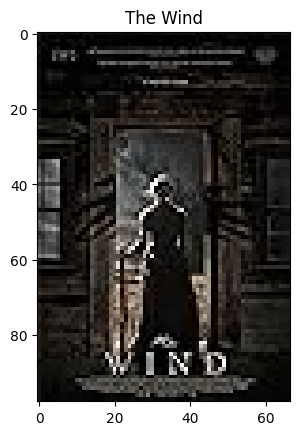

A plains-woman faces the harshness and isolation of the untamed land in the Western frontier of the late 1800s.


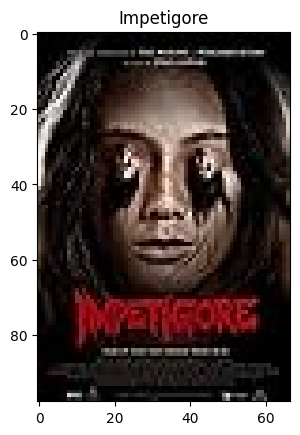

Maya with her best friend, Dini, tries to survive in a city without a family. She realized that she might inherit a property from her rich family. Maya returns to the village with Dini and unaware of the danger was waiting for her.


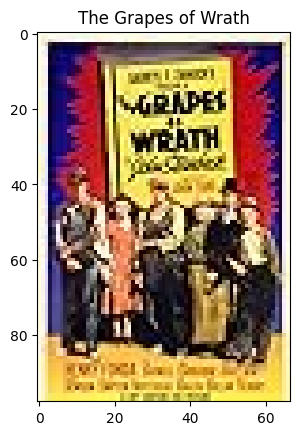

A poor Midwest family is forced off their land. They travel to California, suffering the misfortunes of the homeless in the Great Depression.


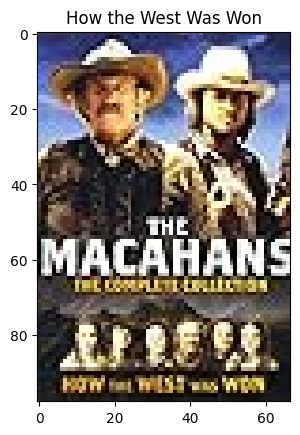

The Macahans, a family from Virginia, headed by Zeb Macahan, travel across the country to pioneer a new land and a new home in the American West.


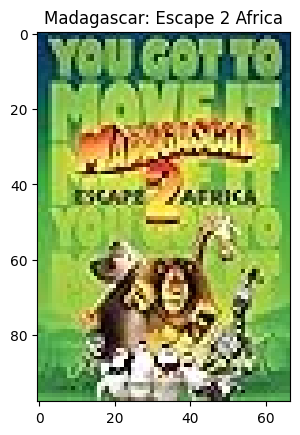

The Madagascar animals fly back to New York City, but crash-land on an African nature reserve, where they meet others of their own kind, and Alex especially discovers his royal heritage as prince of a lion pride.


In [ ]:
show_recommend(recommendations('Yellowstone'))

In [ ]:
def get_tf(word, sentence):
  a = len(sentence)
  b = 0
  for w in sentence:
    if w==word:
      b = b + 1
  return b/a

def get_idf(word, sentences):
  a = len(sentences)
  b = 0
  for sentence in sentences:
    if word in sentence:
      b = b + 1
  return np.log(a/b)

def get_tf_idf(word, sentence, sentences):
  return get_tf(word, sentence) * get_idf(word, sentences)

In [ ]:
def get_avg_tfidf_vec(sentences, model):
  all_sen_vec = []
  for sentence in sentences:
    count = 0
    sen_vec = np.zeros(model.vector_size)
    for word in sentence:
      if word in model.wv.index_to_key:
        sen_vec = sen_vec + model.wv[word] * get_tf_idf(word, sentence, sentences)
        count = count + 1
    avg_vec = sen_vec/count
    all_sen_vec.append(avg_vec)
  return all_sen_vec, len(all_sen_vec)

all_sen_tfidf_vec, all_sen_tfidf_len = get_avg_tfidf_vec(all_desc, google_model)

In [ ]:
def recommendations_tfidf(movie, movies_df=df, all_sen_vec2=all_sen_tfidf_vec):
  df_movie = movies_df.loc[movies_df.Movie==movie]
  index = df_movie.index[0]
  movie_vec1 = all_sen_vec2[index]
  size = len(movies_df)
  top_simil = {}
  for i in range(0, size):
    if i==index:
      continue
    else:
      movie_vec2 = all_sen_vec2[i]
      simil = cosine_similarity(movie_vec1, movie_vec2)
      top_simil[i] = simil
  top_simil = dict(sorted(top_simil.items(), key=lambda item: item[1], reverse=True))
  top_simil_index = list(top_simil.keys())
  top_5 = top_simil_index[0:5]
  return top_5

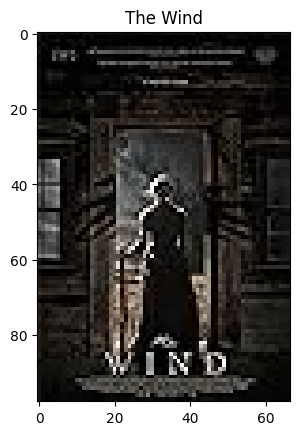

A plains-woman faces the harshness and isolation of the untamed land in the Western frontier of the late 1800s.


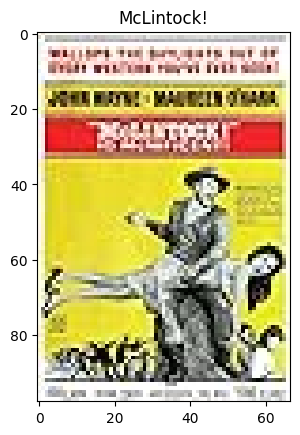

Wealthy rancher G.W. McLintock uses his power and influence in the territory to keep the peace between farmers, ranchers, land-grabbers, Indians and corrupt government officials.


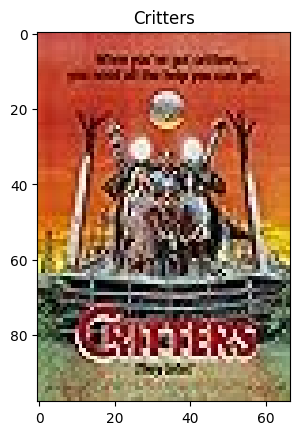

A group of small but vicious alien creatures called Crites escape from an alien prison transport vessel and land near a small farm town on earth, pursued by two shape-shifting bounty hunters.


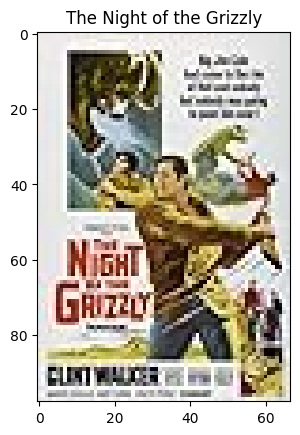

Ex-lawman Jim Cole retires to Wyoming to farm his land, but a land-greedy neighbor, an ex-con turned bounty hunter, and a vicious grizzly bear upset his retirement plans.


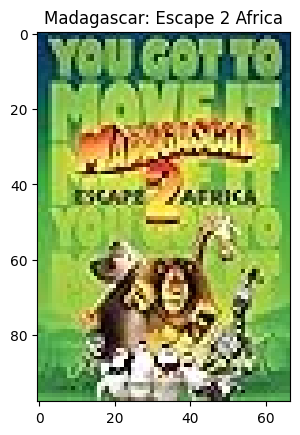

The Madagascar animals fly back to New York City, but crash-land on an African nature reserve, where they meet others of their own kind, and Alex especially discovers his royal heritage as prince of a lion pride.


In [46]:
show_recommend(recommendations_tfidf('Yellowstone'))

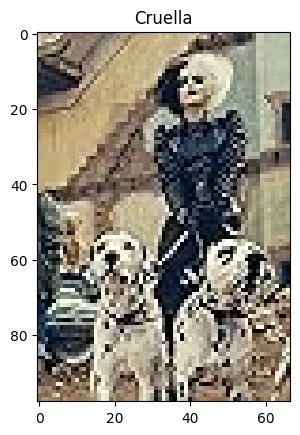

A live-action prequel feature film following a young Cruella de Vil.


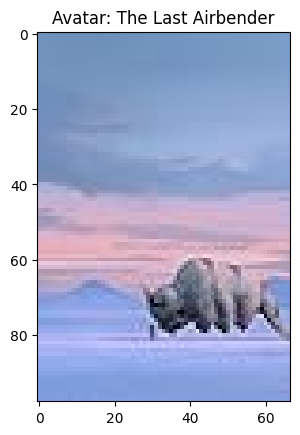

Live-action adaptation of the animated series centering on the adventures of Aang and his friends, who fight to save the world by defeating the Fire-Nation


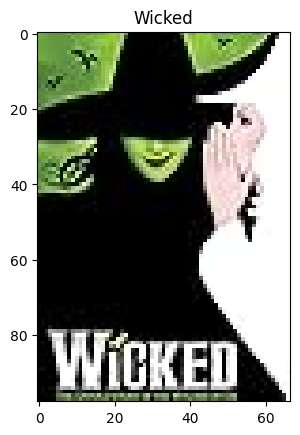

The story of how a green-skinned woman framed by the Wizard of Oz becomes the Wicked Witch of the West; feature film based on the Broadway musical.


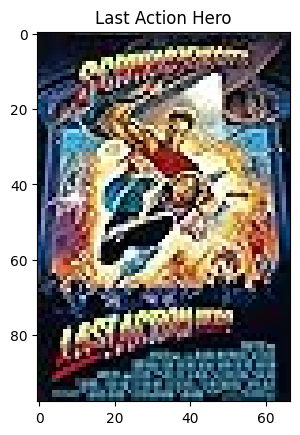

With the help of a magic ticket, a young movie fan is transported into the fictional world of his favorite action movie character.


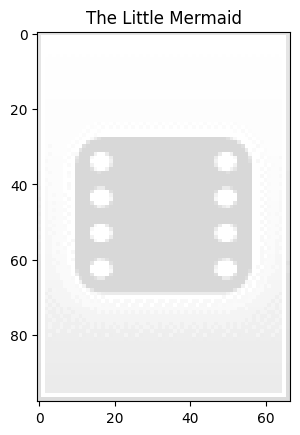

A computer-generated and live-action remake of the 1989 animated Disney movie.


In [52]:
show_recommend(recommendations('Mulan'))

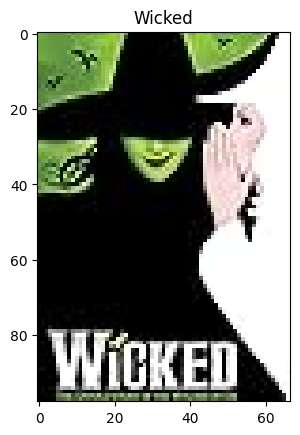

The story of how a green-skinned woman framed by the Wizard of Oz becomes the Wicked Witch of the West; feature film based on the Broadway musical.


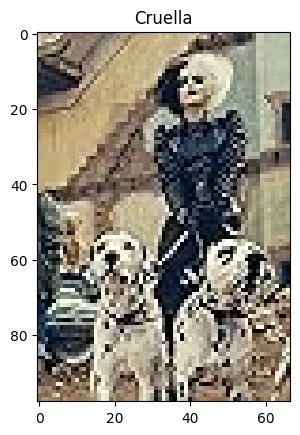

A live-action prequel feature film following a young Cruella de Vil.


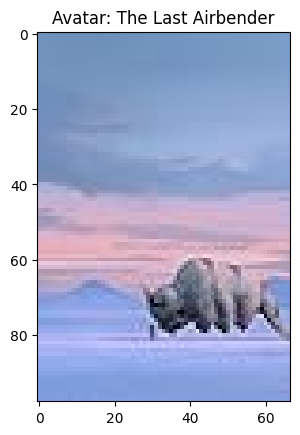

Live-action adaptation of the animated series centering on the adventures of Aang and his friends, who fight to save the world by defeating the Fire-Nation


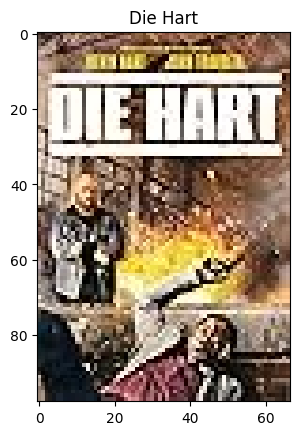

Kevin Hart plays a fictionalized version of himself on a quest to land the action-movie role of a lifetime.


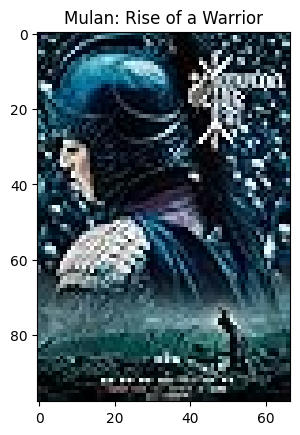

The epic story of the Chinese girl-warrior, Mulan, who fights to defend her father.


In [53]:
show_recommend(recommendations_tfidf('Mulan'))

In [47]:
def recommendations_tfidf_mmr(movie, movies_df=df, all_sen_vec2=all_sen_tfidf_vec, theta=1):
  # Firstly, find the top-most movie:
  df_movie = movies_df.loc[movies_df.Movie==movie]
  index = df_movie.index[0]
  movie_vec1 = all_sen_vec2[index]
  size = len(movies_df)
  top_simil = -100
  top_movie = ''
  top_index = -1
  top_vec = movie_vec1
  movie_list  = []
  vec_list = []
  index_list = []
  for i in range(0, size):
    if i==index:
      continue
    else:
      movie_vec2 = all_sen_vec2[i]
      simil = cosine_similarity(movie_vec1, movie_vec2)
      if simil > top_simil:
        top_simil = simil
        top_movie = movies_df.iloc[i]['Movie']
        top_index = i
        top_vec = movie_vec2
  movie_list.append(top_movie)
  vec_list.append(top_vec)
  index_list.append(top_index)

  # Secondly, add 4 more movies into the list:
  for i in range(0,4):
    top_mr = -100
    top_simil = -100
    top_vec = movie_vec1
    top_movie = ''
    top_index = -1
    for j in range(0, size):
      if j in index_list or j==index:
        continue
      else:
        movie_vec2 = all_sen_vec2[j]
        simil_reward = cosine_similarity(movie_vec1, movie_vec2)
        max_simil_div = -100
        for vec in vec_list:
          simil_div = cosine_similarity(vec, movie_vec2)
          if simil_div > max_simil_div:
            max_simil_div = simil_div
        mr = theta * simil_reward - (1-theta) * max_simil_div
        if mr > top_mr:
          top_mr = mr
          top_movie = movies_df.iloc[j]['Movie']
          top_index = j
          top_simil = movie_vec2
          top_vec = movie_vec2
    movie_list.append(top_movie)
    vec_list.append(top_vec)
    index_list.append(top_index)
  return index_list

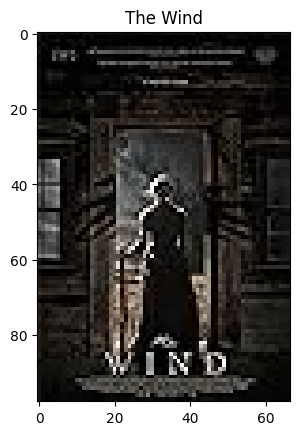

A plains-woman faces the harshness and isolation of the untamed land in the Western frontier of the late 1800s.


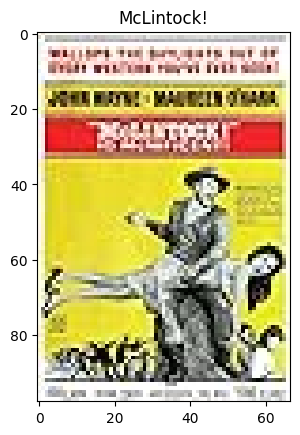

Wealthy rancher G.W. McLintock uses his power and influence in the territory to keep the peace between farmers, ranchers, land-grabbers, Indians and corrupt government officials.


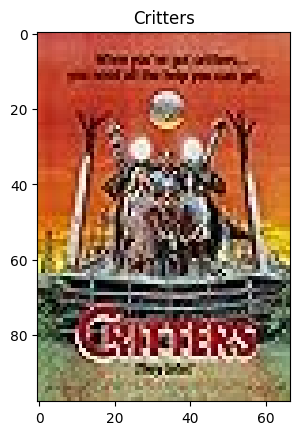

A group of small but vicious alien creatures called Crites escape from an alien prison transport vessel and land near a small farm town on earth, pursued by two shape-shifting bounty hunters.


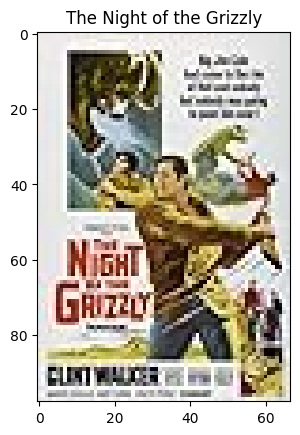

Ex-lawman Jim Cole retires to Wyoming to farm his land, but a land-greedy neighbor, an ex-con turned bounty hunter, and a vicious grizzly bear upset his retirement plans.


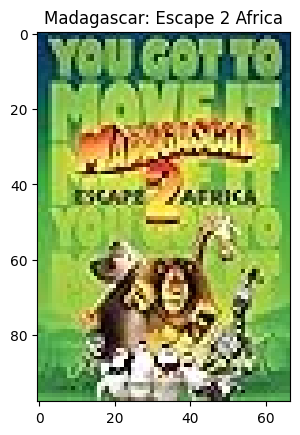

The Madagascar animals fly back to New York City, but crash-land on an African nature reserve, where they meet others of their own kind, and Alex especially discovers his royal heritage as prince of a lion pride.


In [49]:
show_recommend(recommendations_tfidf_mmr('Yellowstone'))
# The same as the non_mmr version since 'theta'=1.

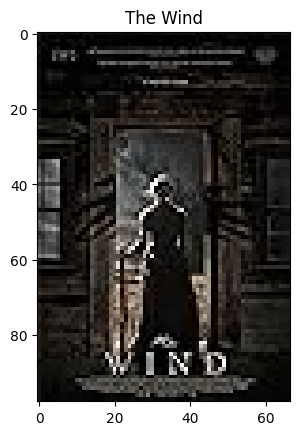

A plains-woman faces the harshness and isolation of the untamed land in the Western frontier of the late 1800s.


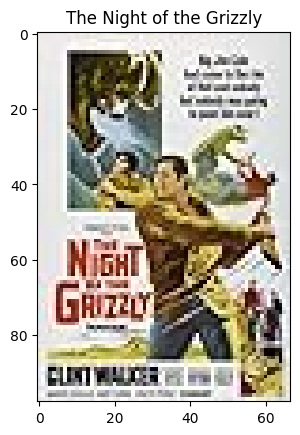

Ex-lawman Jim Cole retires to Wyoming to farm his land, but a land-greedy neighbor, an ex-con turned bounty hunter, and a vicious grizzly bear upset his retirement plans.


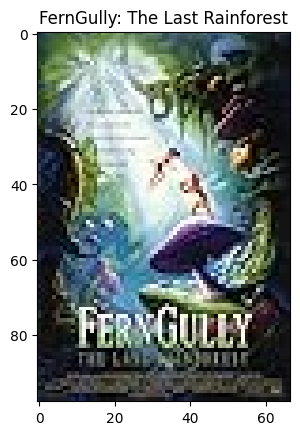

The magical inhabitants of a rainforest fight to save their home, which is threatened by logging and a polluting force of destruction called Hexxus.


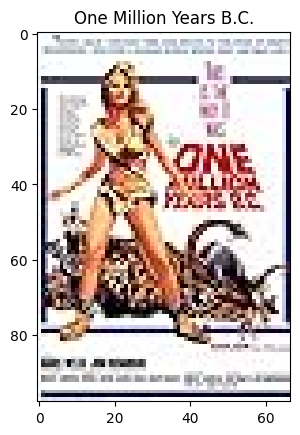

Prehistoric man Tumak is banished from his savage tribe and meets pretty Loana, who belongs to a gentler coastal tribe but he must fight caveman Payto to win her favors.


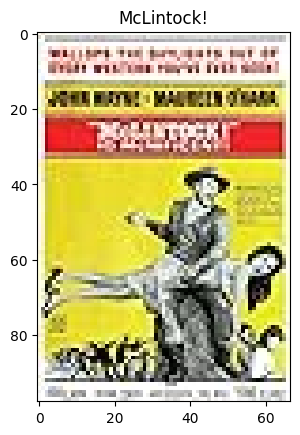

Wealthy rancher G.W. McLintock uses his power and influence in the territory to keep the peace between farmers, ranchers, land-grabbers, Indians and corrupt government officials.


In [51]:
show_recommend(recommendations_tfidf_mmr('Yellowstone', theta=0.6))
# Add more diversity into recommendations.

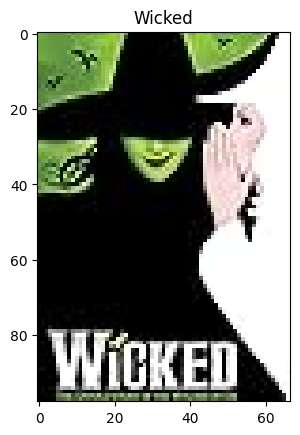

The story of how a green-skinned woman framed by the Wizard of Oz becomes the Wicked Witch of the West; feature film based on the Broadway musical.


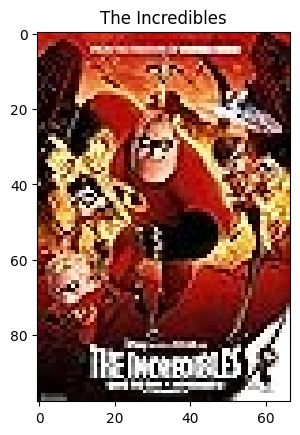

A family of undercover superheroes, while trying to live the quiet suburban life, are forced into action to save the world.


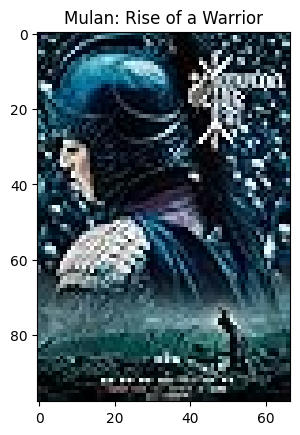

The epic story of the Chinese girl-warrior, Mulan, who fights to defend her father.


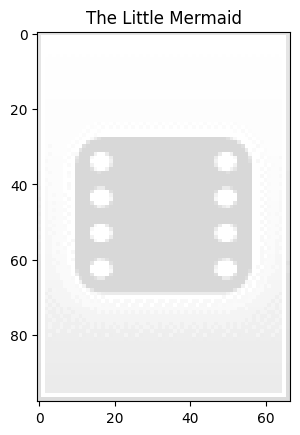

A computer-generated and live-action remake of the 1989 animated Disney movie.


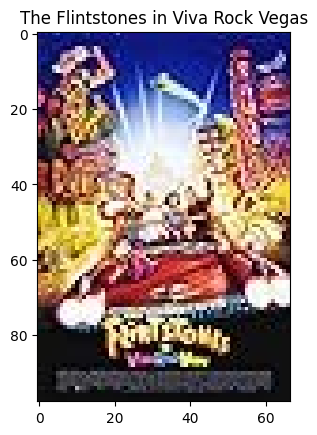

In this live-action prequel to The Flintstones (1994), the Flintstones and the Rubbles go on a trip to Rock Vegas, where Wilma Slaghoople (Kristen Johnston) is pursued by playboy Chip Rockefeller (Thomas Gibson).


In [55]:
show_recommend(recommendations_tfidf_mmr('Mulan', theta=0.6))